# Beta Chain Model Comparisons

## Setup

In [1]:
import os
from pathlib import Path
import sys

if "__project_dir__" not in globals():
    __project_dir__ = Path.cwd().parents[1].resolve()

sys.path.append(__project_dir__)
os.chdir(__project_dir__)

In [2]:
import json
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn

seaborn.set_theme()
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

In [3]:
BENCHMARKING_PARENT_DIR = Path("benchmarks_beta")

In [4]:
metric_dicts = []

for model in BENCHMARKING_PARENT_DIR.iterdir():
    with open(model / "summary.json", "r") as f:
        metric_dicts.append(json.load(f))

In [5]:
def clean_plot(metrics, models):
    embedding_info = metrics.loc[models]
    embedding_info_plot = embedding_info.plot(kind="bar", legend=False)
    plt.ylabel("average precision")
    plt.xlabel("model name")
    return embedding_info_plot

In [6]:
def list_censoring_variants(base_name, censoring_type):
    return [
        f"{base_name} +ACL ({censoring_type} {level})"
        for level in ("0.01", "0.05", "0.10", "0.15", "0.20")
    ]

In [7]:
def plot_pr_curve(ax, model_name, dataset, color):
    precisions = np.load(
        BENCHMARKING_PARENT_DIR / model_name / f"{dataset}_precisions.npy"
    )
    recalls = np.load(BENCHMARKING_PARENT_DIR / model_name / f"{dataset}_recalls.npy")

    ax.step(recalls, precisions, c=color, label=model_name)

In [27]:
def knn_plot(metrics, models, hline=1/29):
    embedding_info = metrics.loc[models]
    embedding_info_plot = embedding_info.plot(kind="bar")
    plt.ylabel("knn score")
    plt.xlabel("model name")
    plt.axhline(hline, color="tab:grey", linestyle="dashed")
    seaborn.move_legend(embedding_info_plot, "upper left", bbox_to_anchor=(1, 1))
    embedding_info_plot.set_ylim(0, 0.3)
    return embedding_info_plot

## Average Precisions

In [9]:
vdjdb_avg_precisions = {
    mdict["model_name"]: mdict["vdjdb"]["avg_precision"] for mdict in metric_dicts
}
vdjdb_avg_precisions = pd.DataFrame.from_dict(vdjdb_avg_precisions, orient="index")
vdjdb_avg_precisions = vdjdb_avg_precisions.sort_values(by=0)

<AxesSubplot: >

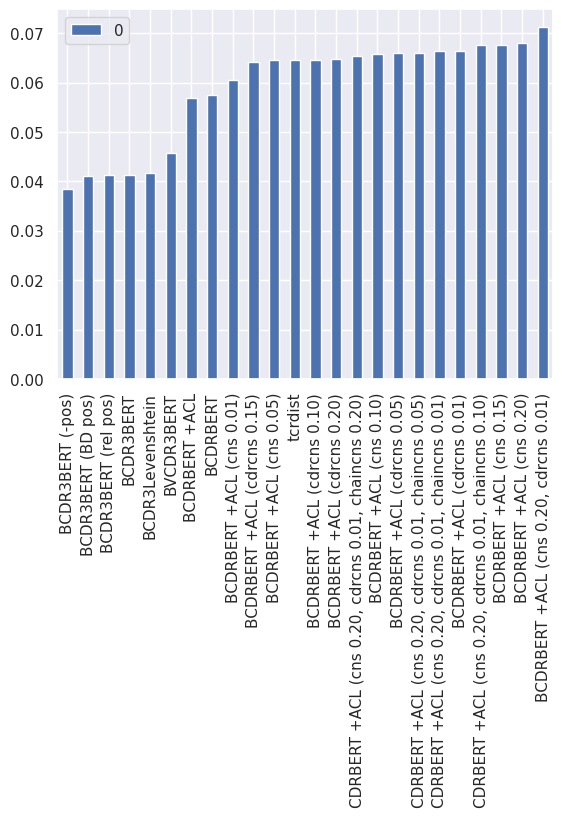

In [10]:
vdjdb_avg_precisions.plot(kind="bar")

[Text(0, 0, 'BCDRBERT +ACL'),
 Text(1, 0, 'BCDRBERT +ACL (cns 0.01)'),
 Text(2, 0, 'BCDRBERT +ACL (cns 0.05)'),
 Text(3, 0, 'BCDRBERT +ACL (cns 0.10)'),
 Text(4, 0, 'BCDRBERT +ACL (cns 0.15)'),
 Text(5, 0, 'BCDRBERT +ACL (cns 0.20)')]

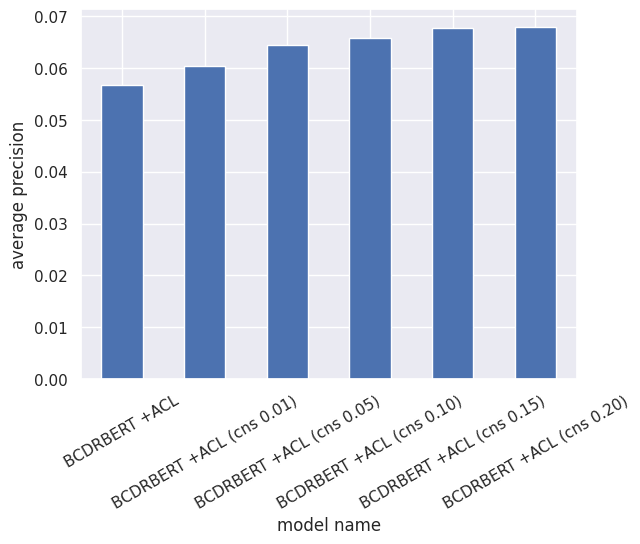

In [11]:
ax = clean_plot(
    vdjdb_avg_precisions, ["BCDRBERT +ACL", *list_censoring_variants("BCDRBERT", "cns")]
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

[Text(0, 0, 'BCDRBERT +ACL'),
 Text(1, 0, 'BCDRBERT +ACL (cdrcns 0.01)'),
 Text(2, 0, 'BCDRBERT +ACL (cdrcns 0.05)'),
 Text(3, 0, 'BCDRBERT +ACL (cdrcns 0.10)'),
 Text(4, 0, 'BCDRBERT +ACL (cdrcns 0.15)'),
 Text(5, 0, 'BCDRBERT +ACL (cdrcns 0.20)')]

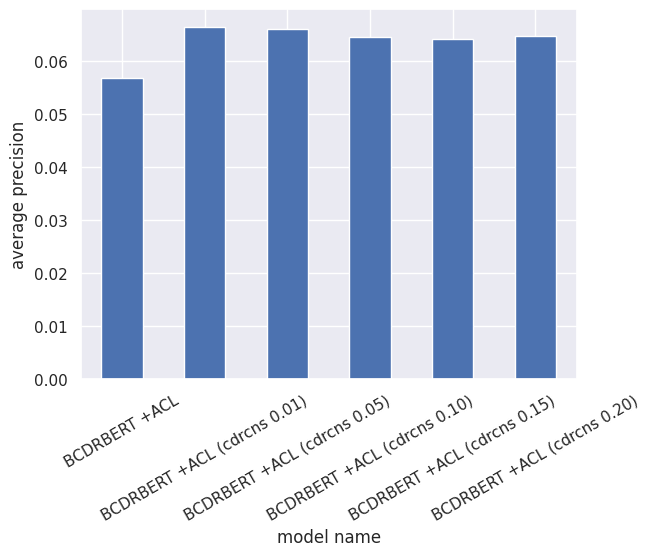

In [12]:
ax = clean_plot(
    vdjdb_avg_precisions,
    ["BCDRBERT +ACL", *list_censoring_variants("BCDRBERT", "cdrcns")],
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

## PR curves

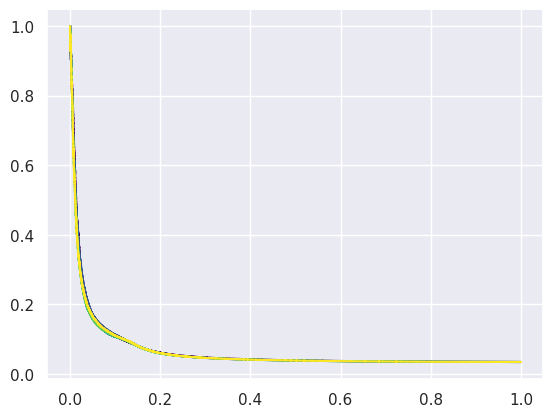

In [13]:
fig, ax = plt.subplots()

models = list_censoring_variants("BCDRBERT", "cdrcns")
colors = pl.cm.viridis(np.linspace(0, 1, len(models)))

for i, model in enumerate(models):
    plot_pr_curve(ax, model, "vdjdb", colors[i])

# ax.set_xlim(0, 0.05)
plt.show()

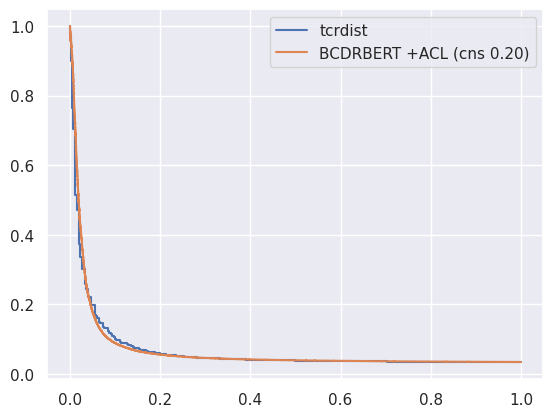

In [14]:
fig, ax = plt.subplots()

models = ["tcrdist", "BCDRBERT +ACL (cns 0.20)"]

for i, model in enumerate(models):
    plot_pr_curve(ax, model, "vdjdb", f"C{i}")

# ax.set_xlim(0, 0.2)
plt.legend()
plt.show()

## k-NN Scores

In [9]:
knn_scores = {
    mdict["model_name"]: mdict["vdjdb"]["knn_scores"] for mdict in metric_dicts
}
knn_scores = pd.DataFrame.from_dict(knn_scores, orient="index")
knn_scores = knn_scores.sort_values(by="5")
knn_scores.columns = knn_scores.columns.map(lambda x: f"k={x}")

<AxesSubplot: >

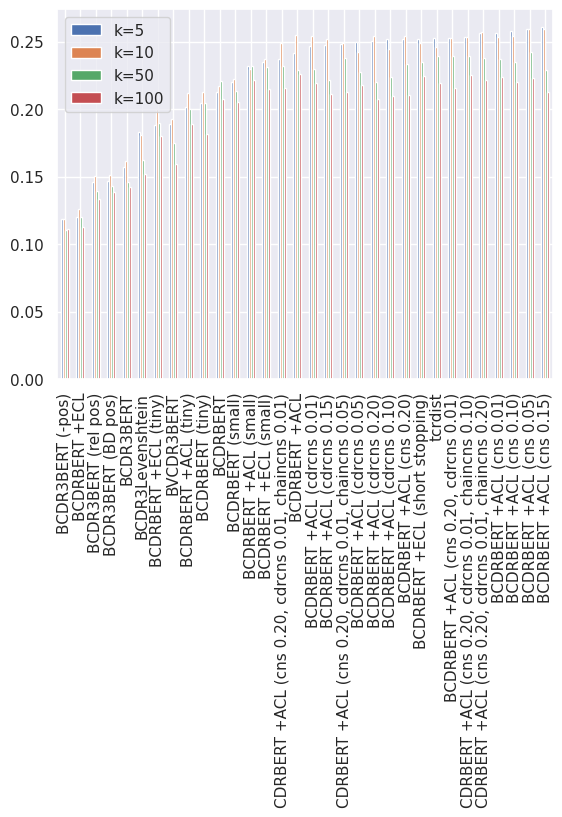

In [10]:
knn_scores.plot(kind="bar")

[Text(0, 0, 'BCDR3Levenshtein'), Text(1, 0, 'tcrdist')]

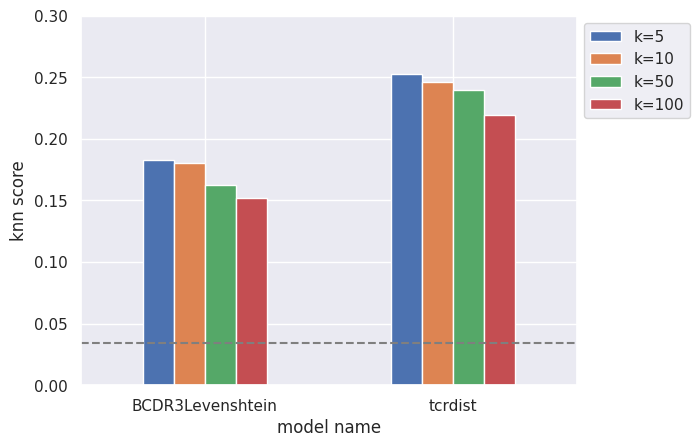

In [11]:
ax = knn_plot(knn_scores, ["BCDR3Levenshtein", "tcrdist"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

[Text(0, 0, 'BCDR3Levenshtein'), Text(1, 0, 'BCDR3BERT')]

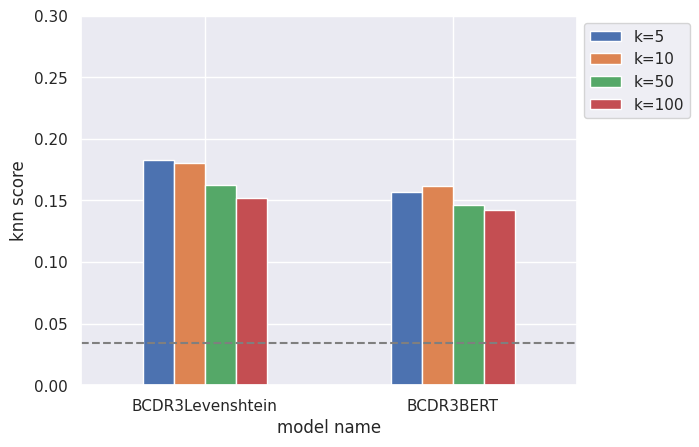

In [14]:
ax = knn_plot(
    knn_scores,
    ["BCDR3Levenshtein", "BCDR3BERT"],
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

[Text(0, 0, 'BCDR3Levenshtein'),
 Text(1, 0, 'BVCDR3BERT'),
 Text(2, 0, 'BCDRBERT'),
 Text(3, 0, 'tcrdist')]

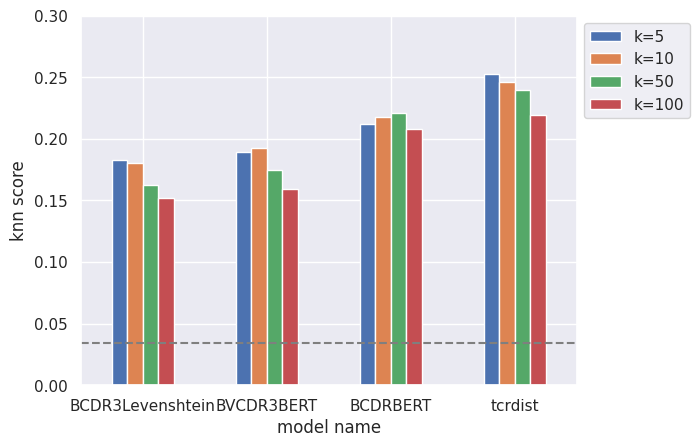

In [16]:
ax = knn_plot(knn_scores, ["BCDR3Levenshtein", "BVCDR3BERT", "BCDRBERT", "tcrdist"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

### Does it learn with autocontrastive learning?

[Text(0, 0, 'tcrdist'), Text(1, 0, 'BCDRBERT +ACL')]

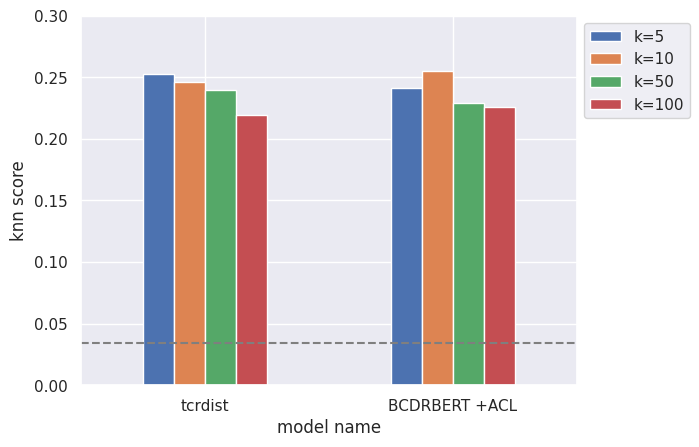

In [17]:
ax = knn_plot(knn_scores, ["tcrdist", "BCDRBERT +ACL"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

### Does autocontrastive learning work better with censoring?

[Text(0, 0, 'BCDRBERT +ACL'),
 Text(1, 0, 'BCDRBERT +ACL (cns 0.10)'),
 Text(2, 0, 'BCDRBERT +ACL (cdrcns 0.10)')]

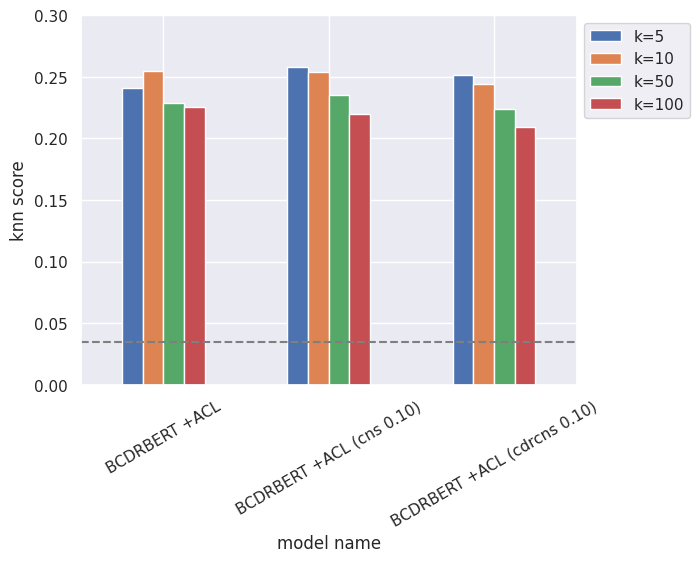

In [33]:
ax = knn_plot(knn_scores, ["BCDRBERT +ACL", "BCDRBERT +ACL (cns 0.10)", "BCDRBERT +ACL (cdrcns 0.10)"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

[Text(0, 0, 'BCDRBERT +ACL (cdrcns 0.01)'),
 Text(1, 0, 'BCDRBERT +ACL (cdrcns 0.05)'),
 Text(2, 0, 'BCDRBERT +ACL (cdrcns 0.10)'),
 Text(3, 0, 'BCDRBERT +ACL (cdrcns 0.15)'),
 Text(4, 0, 'BCDRBERT +ACL (cdrcns 0.20)')]

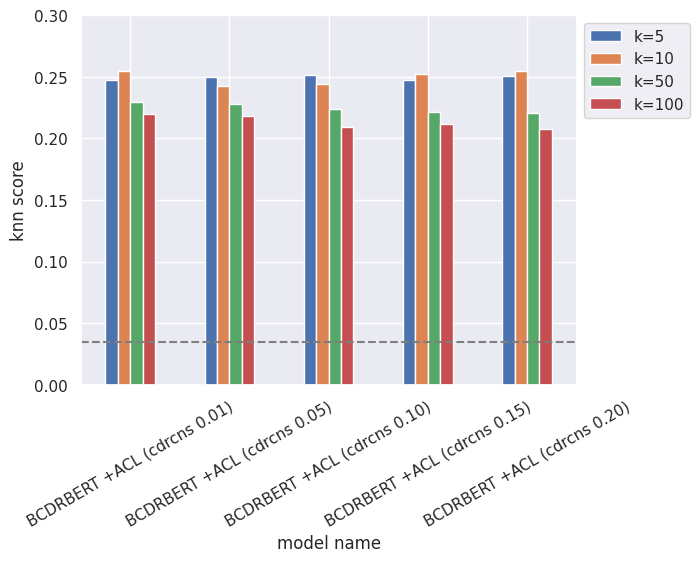

In [22]:
ax = knn_plot(knn_scores, list_censoring_variants("BCDRBERT", "cdrcns"))
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

### VS tcrdist

[Text(0, 0, 'tcrdist'), Text(1, 0, 'BCDRBERT +ACL (cns 0.15)')]

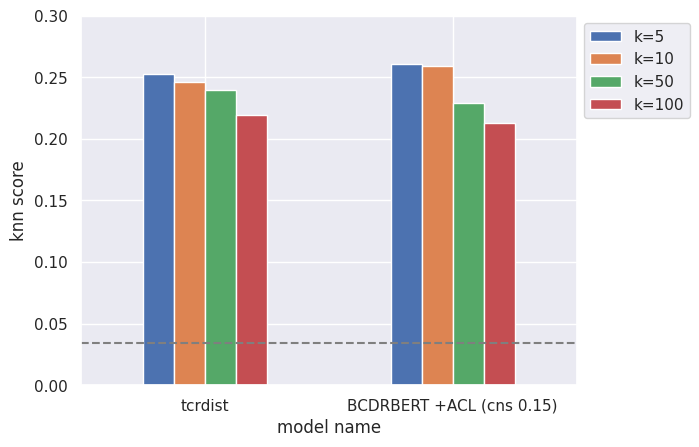

In [23]:
ax = knn_plot(knn_scores, ["tcrdist", "BCDRBERT +ACL (cns 0.15)"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

In [22]:
mira_scores = {
    mdict["model_name"]: mdict["mira"]["knn_scores"] for mdict in metric_dicts if mdict["model_name"] in ("tcrdist", "BCDRBERT +ACL", "BCDRBERT +ECL")
}
mira_scores = pd.DataFrame.from_dict(mira_scores, orient="index")
mira_scores.columns = mira_scores.columns.map(lambda x: f"k={x}")

In [23]:
mira_scores

,k=5,k=10,k=50,k=100
BCDRBERT +ACL,0.234211,0.251579,0.227368,0.219474
tcrdist,0.266702,0.257616,0.221807,0.196152
BCDRBERT +ECL,0.335789,0.356842,0.367895,0.367368


(0.0, 0.4)

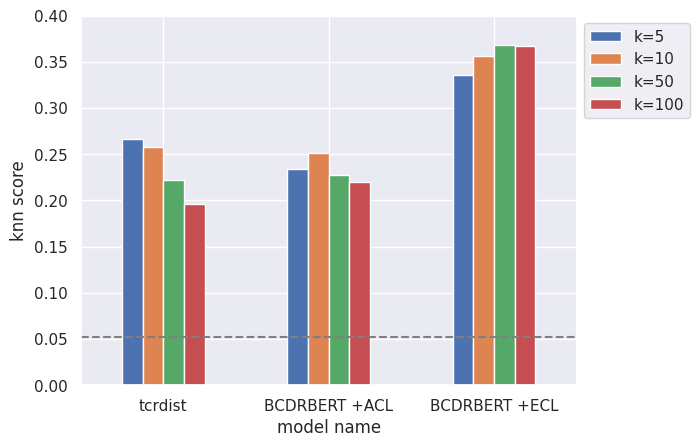

In [28]:
ax = knn_plot(mira_scores, ["tcrdist", "BCDRBERT +ACL", "BCDRBERT +ECL"], hline=1/19)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_ylim(0, 0.4)